In [1]:
import numpy as np
from fasttext import FastVector

# Exploiting similarities among languages

Demo cho phần khai thác sự tương đồng giữa các ngôn ngữ. 
Sử dụng các bộ từ điển vector "từ" đã được huấn luyện từ 2 mô hình Skip-gram hoặc CBOW để khai thác.

# Training function

In [2]:
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

def make_training_matrices(source_dictionary, target_dictionary, bilingual_dictionary):
    """
    Source and target dictionaries are the FastVector objects of
    source/target languages. bilingual_dictionary is a list of 
    translation pair tuples [(source_word, target_word), ...].
    """
    source_matrix = []
    target_matrix = []

    for (source, target) in bilingual_dictionary:
        if source in source_dictionary and target in target_dictionary:
            source_matrix.append(source_dictionary[source])
            target_matrix.append(target_dictionary[target])

    # return training matrices
    return np.array(source_matrix), np.array(target_matrix)

def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

In [3]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

# Loading word embeddings
Load các word_vectors đã được huấn luyện trong **fasttext** gồm "tiếng anh" và "tiếng tây ban nha"
(https://fasttext.cc/docs/en/pretrained-vectors.html)

In [4]:
src_dictionary = FastVector(vector_file='D:\language_data\MUSE-main\data\wiki.en.vec',nmax = 50000)
tgt_dictionary = FastVector(vector_file='D:\language_data\MUSE-main\data\wiki.es.vec',nmax = 50000)

Đánh giá độ tương đồng giữa 2 từ "cat" và "gato"

In [5]:
src_vector = src_dictionary["dog"]
tgt_vector = tgt_dictionary["perro"]
print(FastVector.cosine_similarity(src_vector, tgt_vector))

0.06371806682602589


# Aligning vector

Từ "cat" và "gato" đều có chung 1 nghĩa là "mèo", vì thế nên  cả 2 từ đều có sự tương đồng cao. Nhưng do không gian vector giữa 2 từ chưa được căn chỉnh nên các vector ở 2 bộ này chưa được nhất quán. Để căn chỉnh chúng, ta cần 1 bộ từ điển song ngữ giữa 2 cặp ngôn ngữ.

### 1. Train a transformation matrix

In [6]:
# # Make bilingual dictionary from words pairs with similar text
# src_words = set(src_dictionary.word2id.keys())
# tgt_words = set(tgt_dictionary.word2id.keys())
# overlap = list(src_words & tgt_words)
# bilingual_dictionary = [(entry, entry) for entry in overlap]

In [7]:
#use self learning transformation matrix
# ## form the training matrices
# source_matrix, target_matrix = make_training_matrices(
#     src_dictionary, tgt_dictionary, bilingual_dictionary)
# ## learn and apply the transformation
# transform = learn_transformation(source_matrix, target_matrix)
# src_dictionary.apply_transform(transform)

### 2. Use defaut alignment matrix

In [8]:
# use defaut transformation matrix
src_dictionary.apply_transform('alignment_matrices/en.txt')
tgt_dictionary.apply_transform('alignment_matrices/es.txt')

Đánh giá sự tương đồng giữa "dog" và "perro" sau khi căn chỉnh

In [9]:
src_vector = src_dictionary["dog"]
tgt_vector = tgt_dictionary["perro"]
print(FastVector.cosine_similarity(src_vector, tgt_vector))

0.7750310227531712


Từ số điểm cho thấy có sự tương đồng khá cao giữa hai từ "dog" và "perro"

# Get nearest neighbors

Các từ lận cận của từ "dog" trong "tiếng anh" và "tiếng tây ban nha"

In [10]:
src_embeddings = src_dictionary.embed
tgt_embeddings = tgt_dictionary.embed
src_word2id = src_dictionary.word2id
tgt_word2id = tgt_dictionary.word2id
src_id2word = src_dictionary.id2word
tgt_id2word = tgt_dictionary.id2word

In [11]:
# printing nearest neighbors in the source space
src_word = 'dog'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "dog":
1.0000 - dog
0.8104 - dogs
0.6964 - puppy
0.6762 - puppies
0.6752 - poodle


In [12]:
# printing nearest neighbors in the target space
src_word = 'dog'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "dog":
0.7750 - perro
0.6765 - perros
0.6126 - cachorro
0.6007 - gato
0.5845 - perrito


# Visualize multilingual embeddings on PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.07


In [14]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_dictionary.__getitem__(sw))
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_dictionary.__getitem__(tw))
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

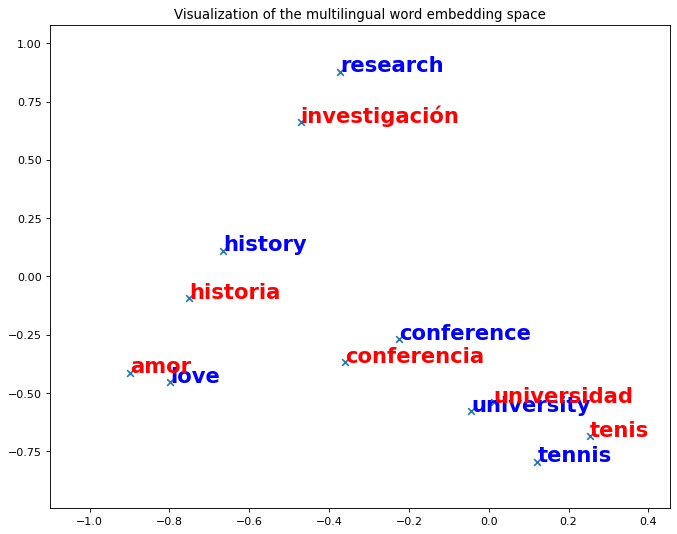

In [15]:
# get 5 random input words
# src_words= ['dog', 'love', 'history', 'tennis', 'research', 'conference', 'cat']
# tgt_words = ['perro', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia','gato']

src_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
tgt_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)